# Synthetic contours

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

import sys
sys.path.append('../')
from helpers import cm2inch, title
matplotlib.style.use('styles.mplstyle')

from src.clusterability.dataset import Dataset
from src.extract.synthesize import MarkovSynthesizer
from src.extract.synthesize import BinomialWalkSynthesizer
from src.clusterability.representations import contour_array

## Markov contour synthesizer

In [2]:
# Load dataset and fit markov synthesizer
dataset = Dataset('combined-phrase')
contours = dataset.representation('pitch')
markov_synthesizer = MarkovSynthesizer()
markov_synthesizer.fit(contours, dataset.df['unit_length'])

binom_synthesizer = BinomialWalkSynthesizer()
binom_synthesizer.fit(dataset.df['unit_length'])

### Initial distribution

Text(0, 0.5, 'density')

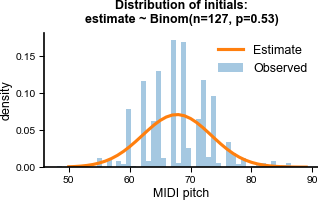

In [3]:
# Plot initial distribution
plt.subplots(1, figsize=cm2inch(6, 3))
I = markov_synthesizer.initial_distr
sns.distplot(contours[:, 0], kde=False, norm_hist=True, label='Observed')
xs = np.arange(50, 90)
plt.plot(xs, I.pmf(xs), label=f'Estimate')
plt.legend()
plt.title(
    f'Distribution of initials:\n'
    f'estimate ~ Binom(n={I.kwds["n"]}, p={I.kwds["p"]:.2f})'
)
plt.xlabel('MIDI pitch')
plt.ylabel('density')

### Transition matrix

Text(0.5, 1, 'Transition probabilities')

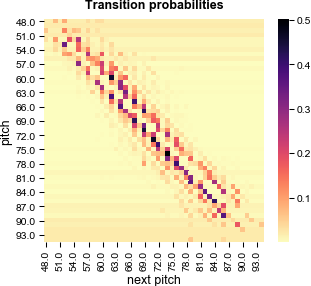

In [4]:
plt.figure(figsize=cm2inch(6, 5))
sns.heatmap(markov_synthesizer.transition_matrix, cmap='magma_r')
plt.xlabel('next pitch')
plt.ylabel('pitch')
plt.title('Transition probabilities')

## Visualize synthetic contours

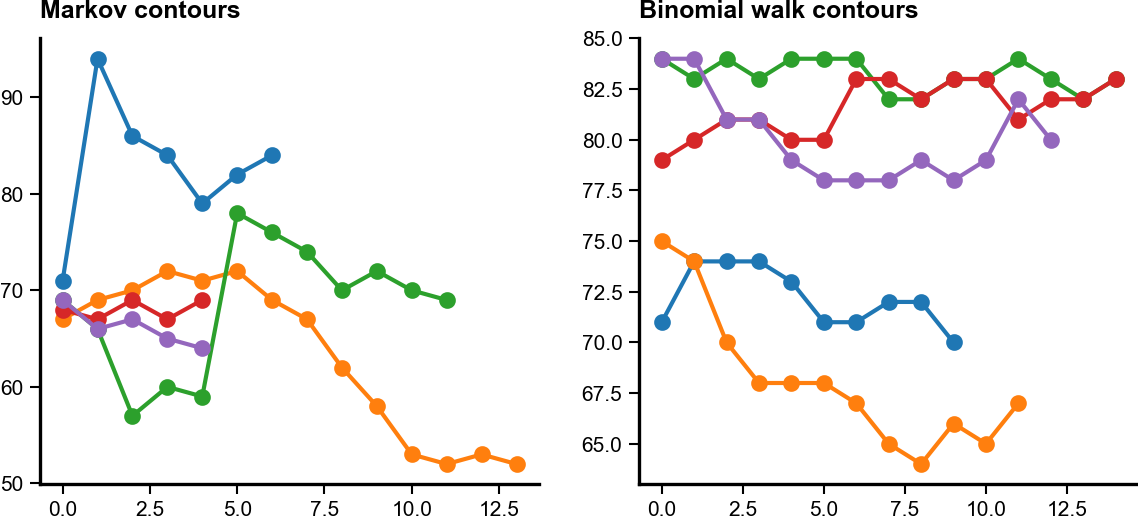

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(12, 5))

for i in range(5):
    ax0.plot(markov_synthesizer.generate(), 'o-', lw=1)
title('Markov contours', ax=ax0)

for i in range(5):
    ax1.plot(binom_synthesizer.generate(), 'o-', lw=1)
title('Binomial walk contours', ax=ax1)

In [6]:
markov_contours = Dataset('markov').representation('pitch', limit=500)
binom_contours = Dataset('binom').representation('pitch', limit=500)

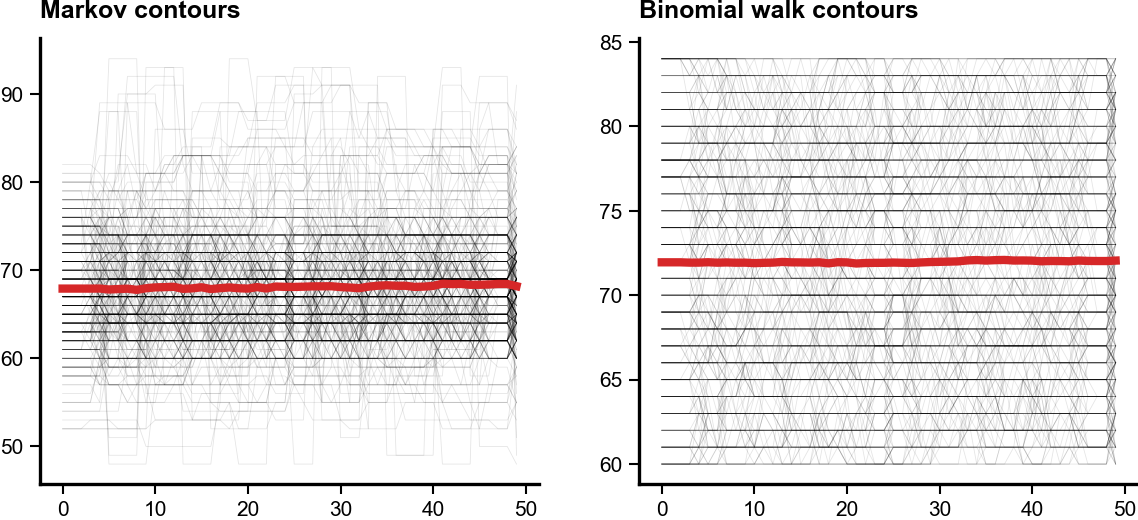

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(12, 5))

ax0.plot(markov_contours.T, 'k-', lw=.2, alpha=.1)
ax0.plot(markov_contours.mean(axis=0), 'C3', lw=2)
title('Markov contours', ax=ax0)

ax1.plot(binom_contours.T, 'k-', lw=.2, alpha=.1)
ax1.plot(binom_contours.mean(axis=0), 'C3', lw=2)
title('Binomial walk contours', ax=ax1)

# PCA

We visualize the principal components of the Markov contours; these should correspond to cosine functions.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
markov_contours = Dataset('markov').representation('pitch')
pca.fit(markov_contours)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'PCA components of synthetic Markov contours')

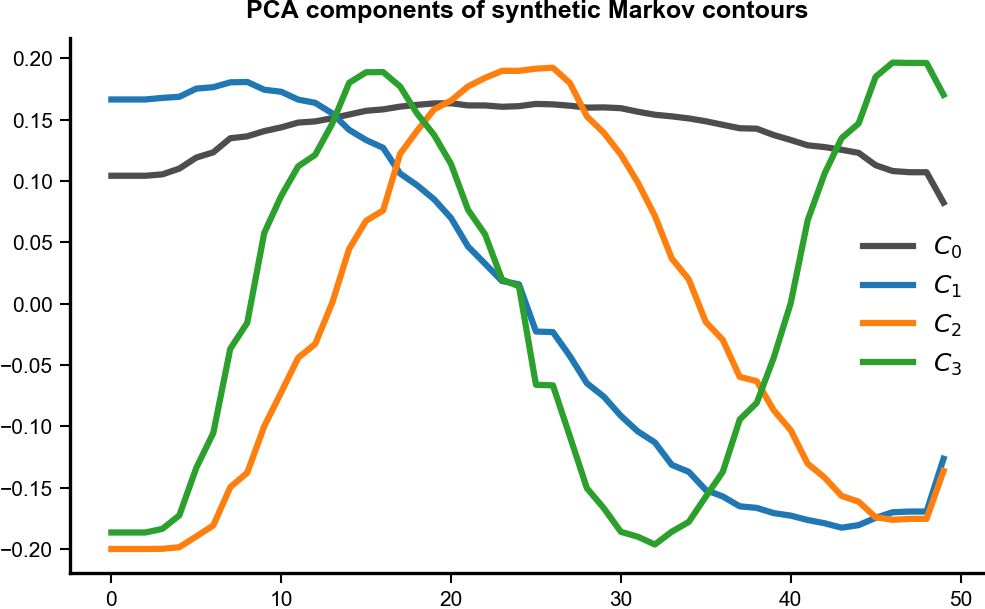

In [9]:
plt.figure(figsize=cm2inch(10,6))
plt.plot(pca.components_[0], '0.3', label='$C_0$')
plt.plot(pca.components_[1], 'C0', label='$C_1$')
plt.plot(pca.components_[2], 'C1', label='$C_2$')
plt.plot(pca.components_[3], 'C2', label='$C_3$')
plt.legend()
plt.title('PCA components of synthetic Markov contours')